# Elevated-Plus Maze Analysis

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import Core
import analysis_utils as au

from scipy import stats
from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display, Math, Latex

InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline

In [2]:
mouse_directory = os.path.expanduser("~") + "/Hen_Lab/Mice"

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)
    
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.startswith("Raw"):
            print("Found: {} in: {}".format(file_name, dir_name))
            raw_files.append(dir_name+"/"+file_name)

Found: Raw_EPM_drd87.csv in: /Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments
Found: Raw_EPM_drd46.csv in: /Users/saveliyyusufov/Hen_Lab/Mice/drd46_experiments


In [3]:
RAW_DRD46 = "~/Hen_Lab/Mice/drd46_experiments/Raw_EPM_drd46.csv"
RAW_DRD87 = "~/Hen_Lab/Mice/drd87_experiments/Raw_EPM_drd87.csv"

data = pd.read_csv(RAW_DRD87, header=None)
z_scored_dataframe, AUC_dataframe, cell_transients_dataframe = Core.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

In [4]:
fig, r_value = au.neuron_scatter_plot_with_reg("neuron38", "neuron45", cell_transients_dataframe)
print("Correlation(neuron38, neuron45) = {}".format(r_value))
au.neuron_line_plot("neuron38", "neuron45", cell_transients_dataframe)

Correlation(neuron38, neuron45) = 0.9204829052193242


### We create a clustermap of all the neurons in the cell transients dataframe using the centroid method, 
$$dist(s,t)= \mid\mid c_s - c_t \mid\mid_2$$
##### where $c_s$ and $c_t$ are the centroids of clusters and $s$ and $t$, respecitvely. When two clusters $s$ and $t$ are combined into a new cluster $u$ the new centroid is computed over all the original objects in clusters $s$ and $t$. The distance then becomes the Euclidean distance between the centroid of $u$ and the centroid of a remaining cluster $v$ in the forest.

##### https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html

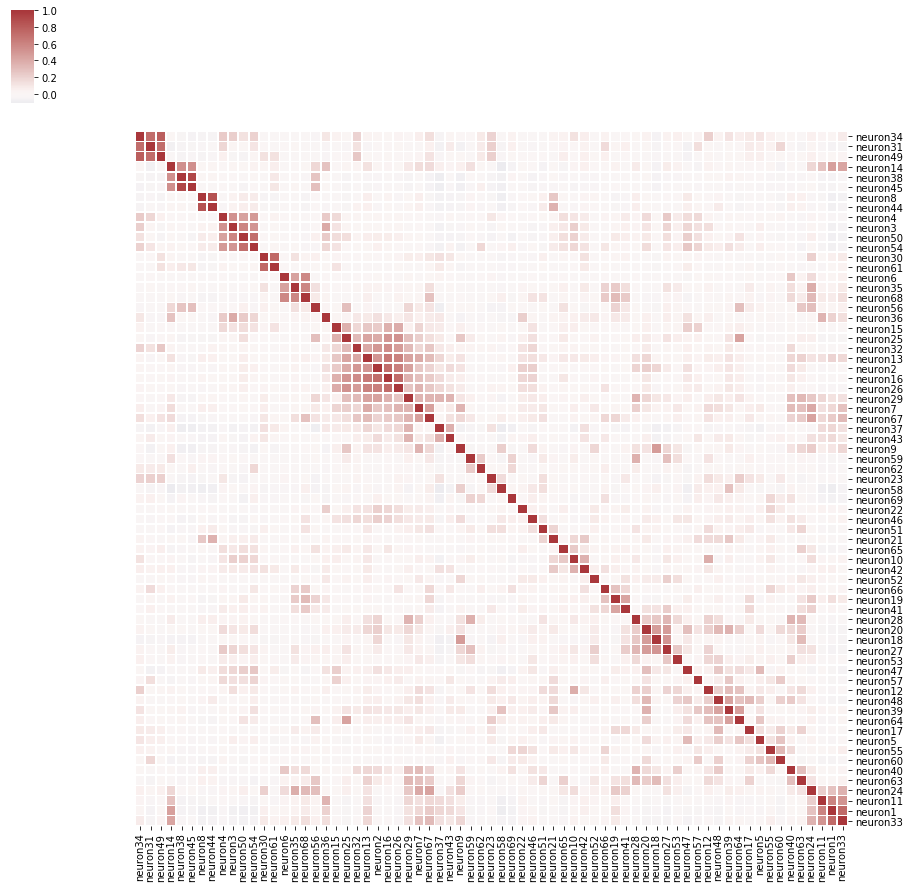

In [5]:
au.plot_clustermap(cell_transients_dataframe)

## How does the relationship between two neurons change as a function of some behavior?

In [6]:
behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

activity_df = pd.read_csv('/Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments/activity_drd87.csv', header=None)
behavior_df = pd.read_csv('/Users/saveliyyusufov/Hen_Lab/Mice/drd87_experiments/behavior_drd87.csv', header=None)

# Save only every nth row in order to downsample behavior Dataframes from 30fps -> 10fps
ROW_MULTIPLE = 3
behavior_df.drop(behavior_df.index[[i for i in range(0, len(behavior_df.index)) if i % ROW_MULTIPLE != 0]], inplace=True)

# For the activity Dataframe, we Change column names to corresponding neuron names 
activity_df.columns = ['neuron' + str(i) for i in range(1, len(activity_df.columns) + 1)]

# Change column names to the behavior column names found in the MossyEPM, MATLAB struct
behavior_df.columns = behavior_column_names

# Fix indexing after downsample
behavior_df.reset_index(drop=True, inplace=True)

# Make the behavior Dataframe indexed by Recording time
# behavior_df.set_index('Recording time', inplace=True)

# Make the behavior Dataframe and the activity Dataframe have the same amount of rows 
if len(behavior_df.index) > len(activity_df.index):
    diff = len(behavior_df.index) - len(activity_df.index)
    behavior_df = behavior_df[:-diff]
elif len(behavior_df.index) < len(activity_df.index):
    diff = len(activity_df.index) - len(behavior_df.index)
    activity_df = activity_df[:-diff]

# Define running frames
VELOCITY_CUTOFF = 4;

# Adds column to the end of the behavior Dataframe and make each cell in that column a 0 
# if the corresponding velocity < VELOCITY_CUTOFF or a 1 if the corresponding velocity >= VELOCITY_CUTOFF
behavior_df['Running_frames'] = [1 if velocity > VELOCITY_CUTOFF else 0 for velocity in behavior_df['Velocity'].tolist()]

# Calculate rates by arm, running, and time period

# Divide session into this many bins
TIME_BIN_FACTOR = 3; 

AUC_dataframe.columns = ['neuron' + str(i) for i in range(1, len(AUC_dataframe.columns)+1)]
result_dataframe = pd.concat([cell_transients_dataframe, behavior_df], axis=1)

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")

behavior_list = ['Running_frames', 'Arena_centerpoint', 'Open1_centerpoint', 'Open2_centerpoint', 'Closed1_centerpoint', 'Closed2_centerpoint', 'OpenArms_centerpoint', 'ClosedArms_centerpoint']

for behavior in behavior_list:    
    _ = sns.lmplot(x="neuron38", y="neuron45", hue=behavior, data=result_dataframe[['neuron38', 'neuron45', 'Arena_centerpoint', 'Open1_centerpoint', 'Open2_centerpoint',
        'Closed1_centerpoint', 'Closed2_centerpoint', 'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Running_frames']], size=8);

In [8]:
def compute_d_rate_NEW(dataframe, neuron_activity_df, *behaviors):
    FRAME_RATE=10
    if len(behaviors) == 1:  
        beh_vec = dataframe.loc[dataframe[behaviors[0]] != 0, neuron_activity_df.columns]
        no_beh_vec = dataframe.loc[dataframe[behaviors[0]] == 0, neuron_activity_df.columns]
        return FRAME_RATE * (beh_vec.values.mean(axis=0) - no_beh_vec.values.mean(axis=0))
    elif len(behaviors) == 2:
        beh_vec = dataframe.loc[dataframe[behaviors[0]] != 0, neuron_activity_df.columns]
        no_beh_vec = dataframe.loc[dataframe[behaviors[1]] != 0, neuron_activity_df.columns]
        return FRAME_RATE * (beh_vec.values.mean(axis=0) - no_beh_vec.values.mean(axis=0))

In [9]:
# result_dataframe.loc[result_dataframe["OpenArms_centerpoint"] != 0]
# result_dataframe.loc[result_dataframe["ClosedArms_centerpoint"] != 0]

# test_compute_d_rate(result_dataframe, cell_transients_dataframe, "OpenArms_centerpoint", "ClosedArms_centerpoint")
compute_d_rate_NEW(result_dataframe, cell_transients_dataframe, "Running_frames")

array([ 0.92543868,  1.86697165,  2.12308754,  1.74374558,  1.35994205,
        0.37797232,  0.9653846 , -0.69801392,  2.62324269,  0.99036496,
        1.00102217,  0.57995418,  1.36129067,  1.50826511,  0.70911388,
        0.89261695,  0.46055506,  3.11566422,  0.87709924,  2.76241587,
       -0.60950736, -0.35552084, -0.61720336,  1.54534017,  1.07165979,
        0.67267013,  3.16548335,  1.77549749,  1.61083372, -0.89124231,
        0.89769058,  0.58638592,  1.92840747,  1.53817835,  1.4755413 ,
        1.5502684 , -1.99018388,  0.83690777,  0.92219878,  0.78878865,
        1.56178564, -0.78291946, -0.8255929 , -0.86633148,  0.7735871 ,
        1.83848701,  1.80635847,  0.25321569,  0.61274674,  2.21915317,
       -0.13164706,  0.36383677,  0.48845414,  1.73994127, -0.31538631,
        1.2427451 ,  1.08879435,  0.30246728,  0.38819522,  0.124988  ,
       -0.41450561,  0.38597172,  1.60970694,  0.97501519,  1.22689907,
        0.65305113,  1.46000142,  1.67992916,  0.78443552])

In [10]:
# Make this function work for multiple behaviors, as discussed on 7 March 2018
def compute_d_rate(dataframe, neuron_activity_df, behavior):
    FRAME_RATE = 10
    beh_vec = dataframe.loc[dataframe[behavior] != 0, neuron_activity_df.columns]
    no_beh_vec = dataframe.loc[dataframe[behavior] == 0, neuron_activity_df.columns]
    return FRAME_RATE * (beh_vec.values.mean(axis=0) - no_beh_vec.values.mean(axis=0))

In [11]:
compute_d_rate(result_dataframe, cell_transients_dataframe, "Running_frames")

array([ 0.92543868,  1.86697165,  2.12308754,  1.74374558,  1.35994205,
        0.37797232,  0.9653846 , -0.69801392,  2.62324269,  0.99036496,
        1.00102217,  0.57995418,  1.36129067,  1.50826511,  0.70911388,
        0.89261695,  0.46055506,  3.11566422,  0.87709924,  2.76241587,
       -0.60950736, -0.35552084, -0.61720336,  1.54534017,  1.07165979,
        0.67267013,  3.16548335,  1.77549749,  1.61083372, -0.89124231,
        0.89769058,  0.58638592,  1.92840747,  1.53817835,  1.4755413 ,
        1.5502684 , -1.99018388,  0.83690777,  0.92219878,  0.78878865,
        1.56178564, -0.78291946, -0.8255929 , -0.86633148,  0.7735871 ,
        1.83848701,  1.80635847,  0.25321569,  0.61274674,  2.21915317,
       -0.13164706,  0.36383677,  0.48845414,  1.73994127, -0.31538631,
        1.2427451 ,  1.08879435,  0.30246728,  0.38819522,  0.124988  ,
       -0.41450561,  0.38597172,  1.60970694,  0.97501519,  1.22689907,
        0.65305113,  1.46000142,  1.67992916,  0.78443552])

## Create dataframe of real $d$ values for all neurons

In [12]:
def set_real_d_df(dataframe, neuron_activity_df, behavior):
    real_df = pd.DataFrame(columns=neuron_activity_df.columns, index=["d"])
    real_df.loc['d'] = compute_d_rate(dataframe, neuron_activity_df, behavior)
    return real_df

In [13]:
real_d_df = set_real_d_df(result_dataframe, cell_transients_dataframe, "Running_frames")
real_d_df

,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron60,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69
d,0.925439,1.86697,2.12309,1.74375,1.35994,0.377972,0.965385,-0.698014,2.62324,0.990365,...,0.124988,-0.414506,0.385972,1.60971,0.975015,1.2269,0.653051,1.46,1.67993,0.784436


In [61]:
def shuffle(n, neuron_activity_df, mouse_behavior_df, behavior):
    """ Homebrewed bootstrapping function for EPM Analysis

    Bootstrapping function that allows estimation of the sample distribution
    using cyclical shifting of the index of a pandas dataframe.

    Args:
        n: the number of random shuffles to be performed on the given data
        neuron_activity_df: the neuron activity dataframe for a given mouse
        mouse_behavior_df: the behavior dataframe for a given mouse 
        (must directly correspond with neuron_activity_df)
        behavior: the behavior to be estimated

    Returns:
        A Pandas DataFrame that contains all the neuron and behavior
        data after all the data has been bootstraped
    """ 
    shifted_beh_df = mouse_behavior_df.copy()
    shuffled_df = pd.DataFrame(columns=neuron_activity_df.columns, index=range(1, n+1))
    for row in shuffled_df.itertuples():
        shifted_beh_df.set_index(np.roll(mouse_behavior_df.index, random.randrange(1, len(mouse_behavior_df.index))), inplace=True)
        shifted_df = pd.concat([neuron_activity_df, shifted_beh_df], axis=1)
        shuffled_df.loc[row.Index] = compute_d_rate(shifted_df, neuron_activity_df, behavior)

    return shuffled_df

In [62]:
bootstrapped = shuffle(1000, cell_transients_dataframe, behavior_df, "Running_frames")

In [139]:
def is_neuron_selective(bootstrapped_df, real_d_df, neuron, behavior):
    # sns.distplot(bootstrapped[neuron].tolist(), color='m', fit=stats.norm);
    # print("87.5th percentile of {} is {},   d_value of {} is {}".format(neuron, np.percentile(bootstrapped[neuron], 87), neuron, real_d_df[neuron]['d']))
    # print(np.percentile(bootstrapped[neuron], 5))
    if real_d_df[neuron]['d'] >= np.percentile(bootstrapped[neuron], 87.5):
        return behavior
    elif real_d_df[neuron]['d'] <= np.percentile(bootstrapped[neuron], 5):
        return "Non-" + behavior
    else: 
        return "Non-selective"

In [140]:
is_neuron_selective(bootstrapped, real_d_df, "neuron42", "Running")

'Non-Running'

In [141]:
running_neurons_dict = {}
for neuron in bootstrapped.columns:
    running_neurons_dict[neuron] = is_neuron_selective(bootstrapped, real_d_df, neuron, "Running")

running_neurons_dict

{'neuron1': 'Non-selective',
 'neuron10': 'Running',
 'neuron11': 'Running',
 'neuron12': 'Non-selective',
 'neuron13': 'Running',
 'neuron14': 'Running',
 'neuron15': 'Non-selective',
 'neuron16': 'Running',
 'neuron17': 'Non-selective',
 'neuron18': 'Running',
 'neuron19': 'Running',
 'neuron2': 'Running',
 'neuron20': 'Running',
 'neuron21': 'Non-selective',
 'neuron22': 'Non-selective',
 'neuron23': 'Non-selective',
 'neuron24': 'Running',
 'neuron25': 'Running',
 'neuron26': 'Running',
 'neuron27': 'Running',
 'neuron28': 'Running',
 'neuron29': 'Running',
 'neuron3': 'Running',
 'neuron30': 'Non-selective',
 'neuron31': 'Running',
 'neuron32': 'Running',
 'neuron33': 'Running',
 'neuron34': 'Running',
 'neuron35': 'Running',
 'neuron36': 'Running',
 'neuron37': 'Non-Running',
 'neuron38': 'Running',
 'neuron39': 'Running',
 'neuron4': 'Running',
 'neuron40': 'Running',
 'neuron41': 'Running',
 'neuron42': 'Non-Running',
 'neuron43': 'Non-selective',
 'neuron44': 'Non-selective',
